Pour ce projet, nous avons suivi le schéma présenté dans cet article:
https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

# Introduction: Home Credit Default Risk Competition
-----------------

## Data

Les données sont fournies par [Home Credit] (http://www.homecredit.net/about-us.aspx), un service dédié à la fourniture de lignes de crédit (prêts) à la population non bancarisée. Prédire si un client remboursera ou non un prêt ou s'il rencontrera des difficultés est un besoin commercial essentiel, et Home Credit organise ce concours sur Kaggle pour voir quel type de modèles la communauté de l'apprentissage automatique peut développer pour l'aider dans cette tâche. 

Il existe 7 sources de données différentes :


* **application_train/application_test**: the main training and testing data avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique `SK_ID_CURR`. Les données du train sont accompagnées de la  `TARGET` qui indique 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé. 
* **bureau**: les données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits antérieurs.
* **bureau_balance**: données mensuelles sur les crédits antérieurs dans le bureau. Chaque ligne correspond à un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit. 
* **previous_application**: les demandes de crédit antérieures auprès de Home Credit. Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts antérieurs. Chaque demande antérieure a une ligne et est identifiée par la caractéristique `SK_ID_PREV`. 
* **POS_CASH_BALANCE**: des données mensuelles sur les prêts au point de vente ou au comptant que les clients ont contractés auprès de Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt au comptant antérieur, et un seul prêt antérieur peut avoir plusieurs lignes.
* **credit_card_balance**: des données mensuelles sur les cartes de crédit que les clients ont eues précédemment avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
* **installments_payment** l'historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué. 



Voir schéma tables pour assemblage : "C:\Users\belou\Projet 7\input\schéma_tables.png"
Voir dico variables : "C:\Users\belou\Projet 7\input\dico_variables.xlsx"

## Metric: ROC AUC

La mesure de classification courante utilisée c'est la COURBE ROC :

https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it
https://en.wikipedia.org/wiki/Receiver_operating_characteristic
https://darwin.unmc.edu/dxtests/roc3.htm


Lorsqu'on mesure une classification en fonction de l'AUC, on ne génère pas des prédictions 0 ou 1, mais plutôt une probabilité entre 0 et 1. Cela peut être déroutant car nous aimons généralement penser en termes de précision, mais lorsque nous rencontrons des problèmes avec des classes déséquilibrées (nous verrons que c'est le cas), la précision n'est pas la meilleure métrique. Par exemple, si je voulais construire un modèle capable de détecter les terroristes avec une précision de 99,9999 %, je me contenterais de créer un modèle prédisant que chaque personne n'est pas un terroriste. Il est clair que cela ne serait pas efficace (le rappel serait nul) et nous utilisons des mesures plus avancées telles que la SSC ROC ou le score F1 pour refléter plus précisément les performances d'un classificateur. 

https://en.wikipedia.org/wiki/F-score

Un modèle ayant un ROC AUC élevé aura également une grande précision, mais l'AUC est une meilleure représentation de la performance du modèle.

https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy


# 1 - Exploration des datasets Train et Test
--------------

Dans ce NB, nous nous en tiendrons à utiliser uniquement les données d'entraînement et de test de l'application principale. Bien que nous devions utiliser toutes les données si nous voulions avoir un espoir de rivaliser sérieusement, nous nous en tiendrons pour l'instant à un seul fichier, ce qui devrait être plus facile à gérer. Cela nous permettra d'établir une base de référence que nous pourrons ensuite améliorer. Dans ce genre de projet, il est préférable de comprendre le problème petit à petit plutôt que de s'y plonger complètement et de s'y perdre ! 

## 1.1 - Imports


In [1]:
import mlflow
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from mlflow.models import infer_signature

import shap
# Memory management
import gc 

## 1.2 - Read in Data 

In [2]:
# List files available
print(os.listdir("../input/"))

['.ipynb_checkpoints', '1- Exploration et 1ères modélisations.ipynb', '2_Feature-engineering_1.ipynb', '3_introduction-to-manual-feature-engineering_2.ipynb', '4_Feature_Selection.ipynb', '5_new_lgbm_95_percent.ipynb', '6_new_lgbm_30_features.ipynb', '7_shap sur lgbm_95_percent.ipynb', '8_evidently.ipynb', 'application_test.csv', 'application_train.csv', 'app_test_domain.csv', 'app_train_domain.csv', 'archives', 'baseline_lgb.csv', 'baseline_lgb_domain_features.csv', 'bureau.csv', 'bureaux.csv', 'bureau_balance.csv', 'bureau_balances.csv', 'credit_card_balance.csv', 'credit_card_balances.csv', 'data_drift_report.html', 'dico_train_test.csv', 'dico_variables.xlsx', 'feature_importances_sorted_lgbm_1.csv', 'file.html', 'HomeCredit_columns_description.csv', 'installments_payment.csv', 'installments_payments.csv', 'log_reg_baseline.csv', 'methodo.xlsx', 'm_train_small.csv', 'POS_CASH_balance.csv', 'POS_CASH_balances.csv', 'previous_application.csv', 'previous_applications.csv', 'random_for

In [3]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Le train comporte 307511 observations (chacune étant un prêt distinct) et 122 variables, y compris la target

In [4]:
# Testing data features
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Le test comporte bcp moins d'observations (48744) et ne comporte pas de  TARGET. Nous n'en tiendrons pas compte dans un 1er temps

## 1.3 - Exploratory Data Analysis

### 1.3.1 -  Distribution de la target

In [5]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [6]:
app_train['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

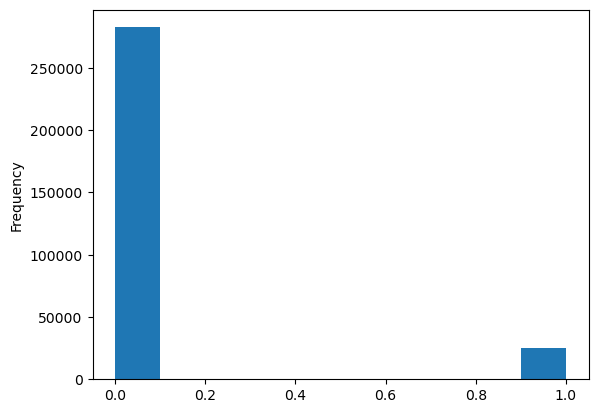

In [7]:
app_train['TARGET'].plot.hist();

Ces informations montrent qu'il s'agit d'un problème de classe déséquilibrée :  http://www.chioka.in/class-imbalance-problem/. 

Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Lorsque nous utiliserons des modèles d'apprentissage automatique plus sophistiqués, nous pourrons pondérer les classes : http://xgboost.readthedocs.io/en/latest/parameter.html en fonction de leur représentation dans les données afin de refléter ce déséquilibre :

- scale_pos_weight : C'est l'un des hyperparamètres les plus importants pour les ensembles de données déséquilibrés dans les problèmes de classification binaire. Ce paramètre donne plus de poids à la classe minoritaire pendant l'entraînement, aidant le modèle à accorder une attention appropriée à cette classe.
- max_delta_step : Cet hyperparamètre aide à rendre la mise à jour du gradient plus conservatrice, souvent utile dans les ensembles de données très déséquilibrés. Il est généralement utilisé en conjonction avec scale_pos_weight pour améliorer la performance du modèle.

Paramètres relatifs à l'échantillonnage :

- subsample : Le pourcentage d'échantillons utilisés pour chaque arbre. Réduire cette valeur peut aider à éviter le surajustement.
- colsample_bytree, colsample_bylevel, colsample_bynode : Ces paramètres contrôlent le sous-échantillonnage des caractéristiques à différents niveaux de la construction des arbres. Ils peuvent être utiles pour gérer les surajustements.

En général, ajuster scale_pos_weight est un bon point de départ pour traiter des ensembles de données déséquilibrés. Il est également recommandé de faire une validation croisée pour déterminer les valeurs optimales de ces hyperparamètres pour votre ensemble de données spécifique.

### 1.3.2 - Missing Values

In [8]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, print_info = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Lorsqu'il s'agira de construire nos modèles d'apprentissage automatique, nous devrons imputer ces valeurs manquantes. Dans un travail ultérieur, nous utiliserons des modèles tels que XGBoost qui peuvent traiter les valeurs manquantes sans nécessiter d'imputation : https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase.
Une autre option consisterait à supprimer les colonnes présentant un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. 
Par conséquent, nous conserverons toutes les colonnes pour l'instant.

### 1.3.3 - Column Types

In [10]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [11]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques.

### 1.3.4 - Anomalies

Les anomalies dans les données sont un problème que nous devons toujours surveiller lorsque nous faisons de l'AED. Celles-ci peuvent être dues à des chiffres mal saisis, à des erreurs dans les mesures ou à des mesures valables mais extrêmes. L'une des façons de détecter les anomalies de manière quantitative est d'examiner les statistiques d'une colonne à l'aide de la méthode `describe`. 

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

Les chiffres de la colonne `DAYS_BIRTH` sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année :

In [14]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité supérieure ou inférieure. Qu'en est-il des jours d'emploi ? 

In [15]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Cela ne semble pas correct ! La valeur maximale (en plus d'être positive) est d'environ 1000 ans !

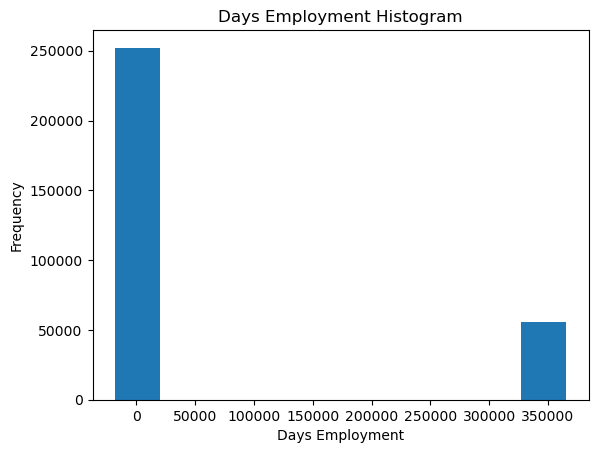

In [16]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Par simple curiosité, nous allons regrouper les clients présentant des anomalies et voir s'ils ont tendance à avoir des taux de défaillance plus élevés ou plus faibles que le reste des clients.

In [17]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Il s'avère que les anomalies ont un taux de défaillance plus faible. 

Le traitement des anomalies dépend de la situation exacte et il n'existe pas de règles fixes. L'une des approches les plus sûres consiste à définir les anomalies comme des valeurs manquantes et à les compléter (à l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, comme toutes les anomalies ont exactement la même valeur, nous voulons les compléter avec la même valeur au cas où tous ces prêts auraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, c'est pourquoi nous voulons indiquer au modèle d'apprentissage automatique si nous avons effectivement renseigné ces valeurs. Comme solution, nous allons remplir les valeurs anormales avec un nombre (`np.nan`) et ensuite créer une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.



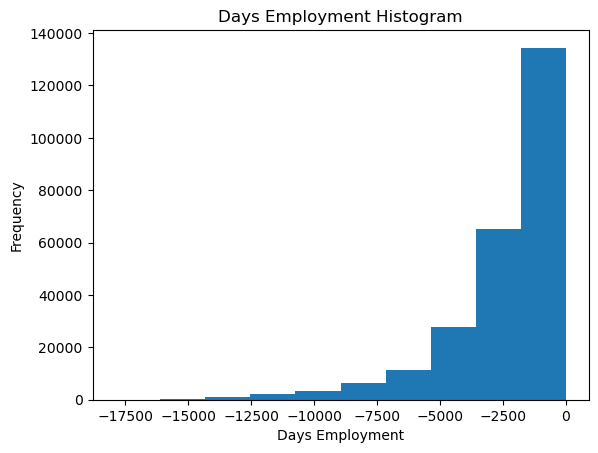

In [18]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Tout ce que nous faisons sur les données d'entraînement, nous devons également le faire sur les données de test. Veillons à créer la nouvelle colonne et à remplir la colonne existante avec np.nan dans les données de test.

In [19]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


La distribution semble beaucoup plus conforme à ce que nous attendons, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales (parce que nous devrons remplir les nans avec une valeur, probablement la médiane de la colonne). Les autres colonnes avec `DAYS` dans le cadre de données semblent être à peu près ce que nous attendons, sans valeurs aberrantes évidentes. 

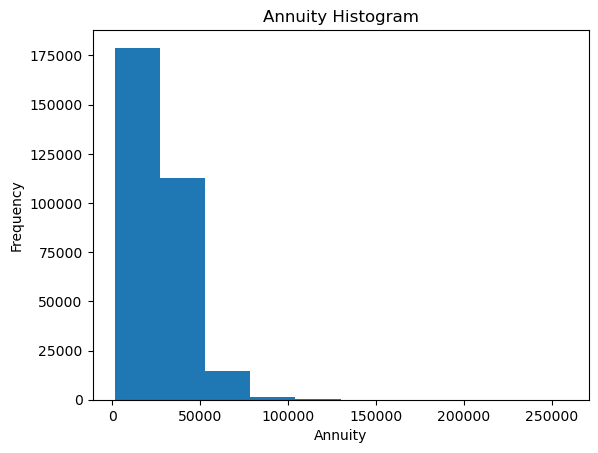

In [20]:
app_train['AMT_ANNUITY'].plot.hist(title = 'Annuity Histogram');
plt.xlabel('Annuity');

### 1.3.5 - Correlations

Une façon d'essayer de comprendre les données est de rechercher des corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible à l'aide de la méthode .corr dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la « pertinence » d'une caractéristique, mais il nous donne une idée des relations possibles entre les données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [21]:
numeric_columns=app_train.select_dtypes(include=np.number).columns.tolist()
numeric_columns

# Matrice de corrélation
correlations = app_train[numeric_columns].corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227


La corrélation `DAYS_BIRTH` est la plus positive. En regardant la documentation, `DAYS_BIRTH` est l'âge en jours du client au moment du prêt en jours négatifs (pour une raison quelconque !). La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire la cible == 0). C'est un peu déroutant, nous prendrons donc la valeur absolue de la caractéristique et la corrélation sera négative.

#### 1.3.5.1 - Effect of Age on Repayment

In [22]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

Plus le client est âgé, plus il existe une relation linéaire négative avec la cible, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps. 

Commençons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. L'axe des x sera exprimé en années pour rendre le graphique un peu plus compréhensible.

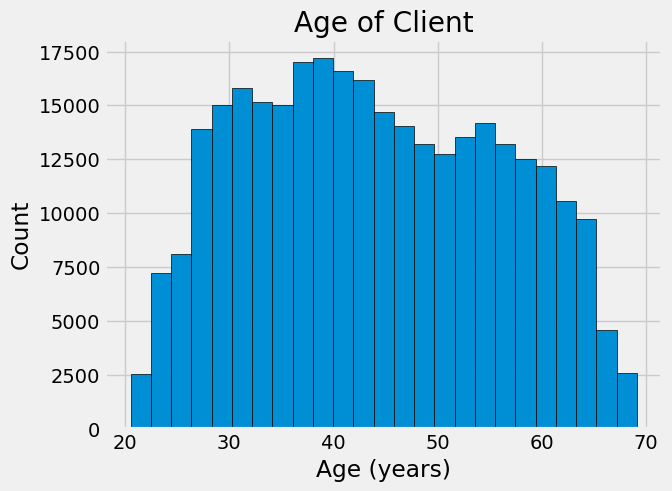

In [23]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

En soi, la distribution de l'âge ne nous apprend pas grand-chose, si ce n'est qu'il n'y a pas de valeurs aberrantes puisque tous les âges sont raisonnables.
Pour visualiser l'effet de l'âge sur la cible, nous ferons ensuite un graphique d'estimation de la densité du noyau (KDE) coloré par la valeur de la cible. Un graphique d'estimation de la densité du noyau montre la distribution d'une seule variable et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement une gaussienne, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons le `kdeplot` de seaborn pour ce graphique.

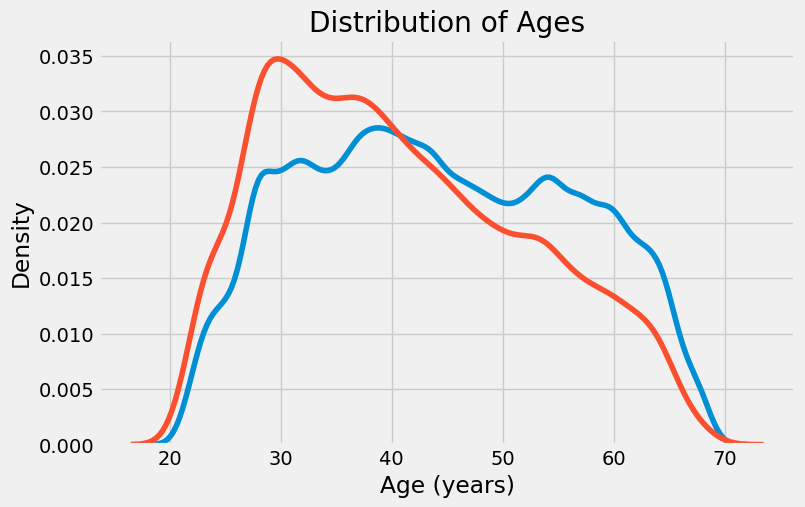

In [24]:
plt.figure(figsize = (8, 5))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

La courbe de la Target == 1 penche vers l'extrémité la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des prêts par tranche d'âge. 

Pour créer ce graphique, nous commençons par « découper » la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [25]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [26]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


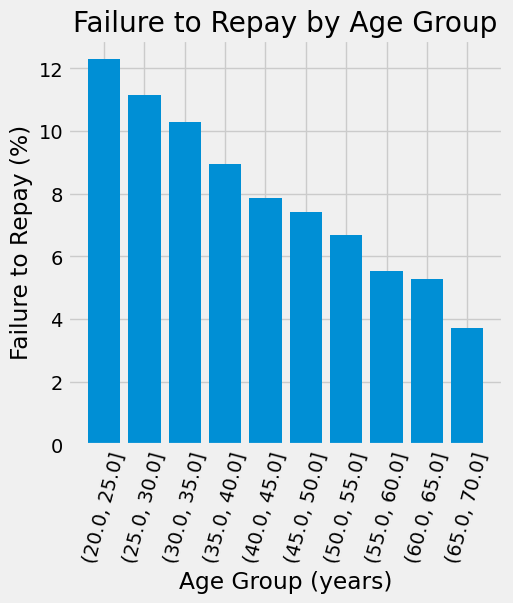

In [27]:
plt.figure(figsize = (5, 5))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

La tendance est claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d'âge les plus jeunes et inférieur à 5 % pour le groupe le plus âgé.

Il s'agit d'une information qui pourrait être directement utilisée par la banque : étant donné que les jeunes clients sont moins susceptibles de rembourser le prêt, il conviendrait peut-être de leur fournir davantage de conseils ou d'astuces en matière de planification financière. Cela ne signifie pas que la banque doive discriminer les jeunes clients, mais il serait judicieux de prendre des mesures de précaution pour les aider à rembourser à temps.

#### 1.3.5.2 - Exterior Sources

Les 3 variables ayant les corrélations négatives les plus fortes avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`.
Selon la documentation, ces caractéristiques représentent un « score normalisé de la source de données externe ». Je ne suis pas sûr de ce que cela signifie exactement, mais il pourrait s'agir d'une sorte d'évaluation de crédit cumulative réalisée à partir de nombreuses sources de données. 

Examinons ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques `EXT_SOURCE` avec la cible et entre elles.

In [28]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


In [29]:
# plt.figure(figsize = (8, 6))

# # Heatmap of correlations
# sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
# plt.title('Correlation Heatmap');

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également constater que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'âge du client est peut-être l'un des facteurs de ce score.

Nous pouvons ensuite examiner la distribution de chacune de ces caractéristiques en fonction de la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

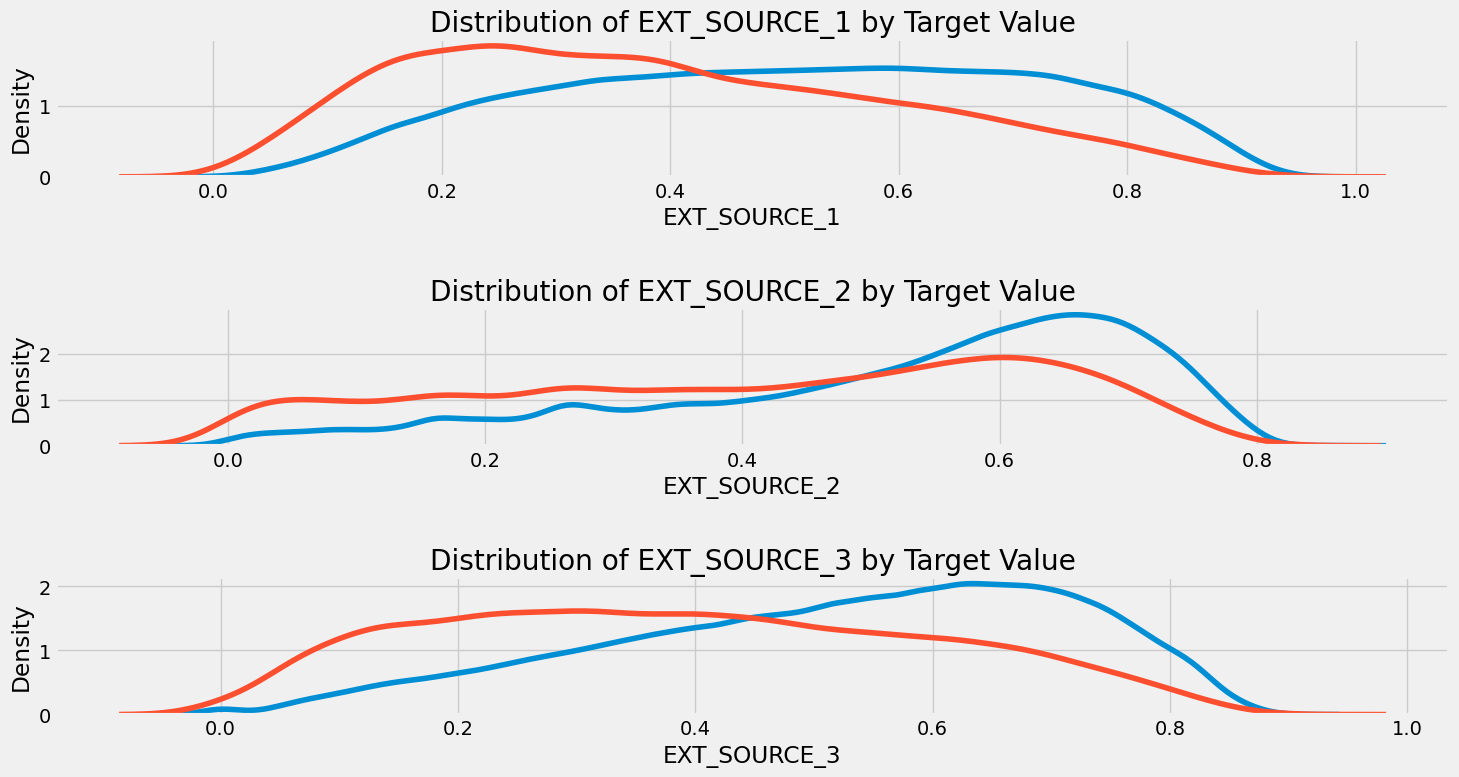

In [30]:
plt.figure(figsize = (15, 8))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles, mais ces variables seront toujours utiles pour un modèle d'apprentissage automatique permettant de prédire si un demandeur remboursera ou non un prêt dans les délais.

### 1.3.6 - Pairs Plot

En guise de dernier graphique exploratoire, nous pouvons faire un pairplot des variables `EXT_SOURCE` et de la variable `DAYS_BIRTH`. Le Pairplot (https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) est un excellent outil d'exploration car il nous permet de voir les relations entre plusieurs paires de variables ainsi que les distributions de variables uniques. 

In [31]:
# # Copy the data for plotting
# plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# # Add in the age of the client in years
# plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# # Drop na values and limit to first 100000 rows
# plot_data = plot_data.dropna().loc[:100000, :]

# # Function to calculate correlation coefficient between two columns
# def corr_func(x, y, **kwargs):
#     r = np.corrcoef(x, y)[0][1]
#     ax = plt.gca()
#     ax.annotate("r = {:.2f}".format(r),
#                 xy=(.2, .8), xycoords=ax.transAxes,
#                 size = 20)

# # Create the pairgrid object
# grid = sns.PairGrid(data = plot_data, height = 3, diag_sharey=False,
#                     hue = 'TARGET', 
#                     vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# # Upper is a scatter plot
# grid.map_upper(plt.scatter, alpha = 0.2)

# # Diagonal is a histogram
# grid.map_diag(sns.kdeplot)

# # Bottom is density plot
# grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

# plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

Dans ce graphique, le rouge indique les prêts non remboursés et le bleu les prêts remboursés. Nous pouvons voir les différentes relations au sein des données. Il semble y avoir une relation linéaire positive modérée entre EXT_SOURCE_1 et DAYS_BIRTH (ou YEARS_BIRTH), ce qui indique que cette caractéristique peut prendre en compte l'âge du client.

## 1.4 - Feature Engineering

Le Feature Engineering a un meilleur retour sur investissement que la construction de modèles et l'ajustement des hyperparamètres. 

Feature Engineering se réfère à un processus général et peut impliquer à la fois la construction de caractéristiques : l'ajout de nouvelles caractéristiques à partir des données existantes, et la sélection de caractéristiques : le choix des caractéristiques les plus importantes ou d'autres méthodes de réduction de la dimensionnalité. Il existe de nombreuses techniques permettant de créer et de sélectionner des caractéristiques.


Nous pouvons créer quelques caractéristiques qui tentent de capturer ce que nous pensons être important pour savoir si un client va manquer à ses obligations de remboursement d'un prêt. Ici, je vais utiliser cinq caractéristiques qui ont été inspirées par ce script (https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) d'Aguiar :

* `CREDIT_INCOME_PERCENT` : le pourcentage du montant du crédit par rapport au revenu du client.
* `ANNUITY_INCOME_PERCENT` : le pourcentage de l'annuité du prêt par rapport au revenu du client
* `CREDIT_TERM` : la durée du paiement en mois (puisque l'annuité est le montant mensuel dû).
* `DAYS_EMPLOYED_PERCENT` : le pourcentage des jours de travail par rapport à l'âge du client.


In [32]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [33]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

Nous devrions explorer ces variables de __connaissance du domaine__ visuellement dans un graphique. Pour toutes ces variables, nous ferons le même graphique KDE coloré par la valeur de la `TARGET`.

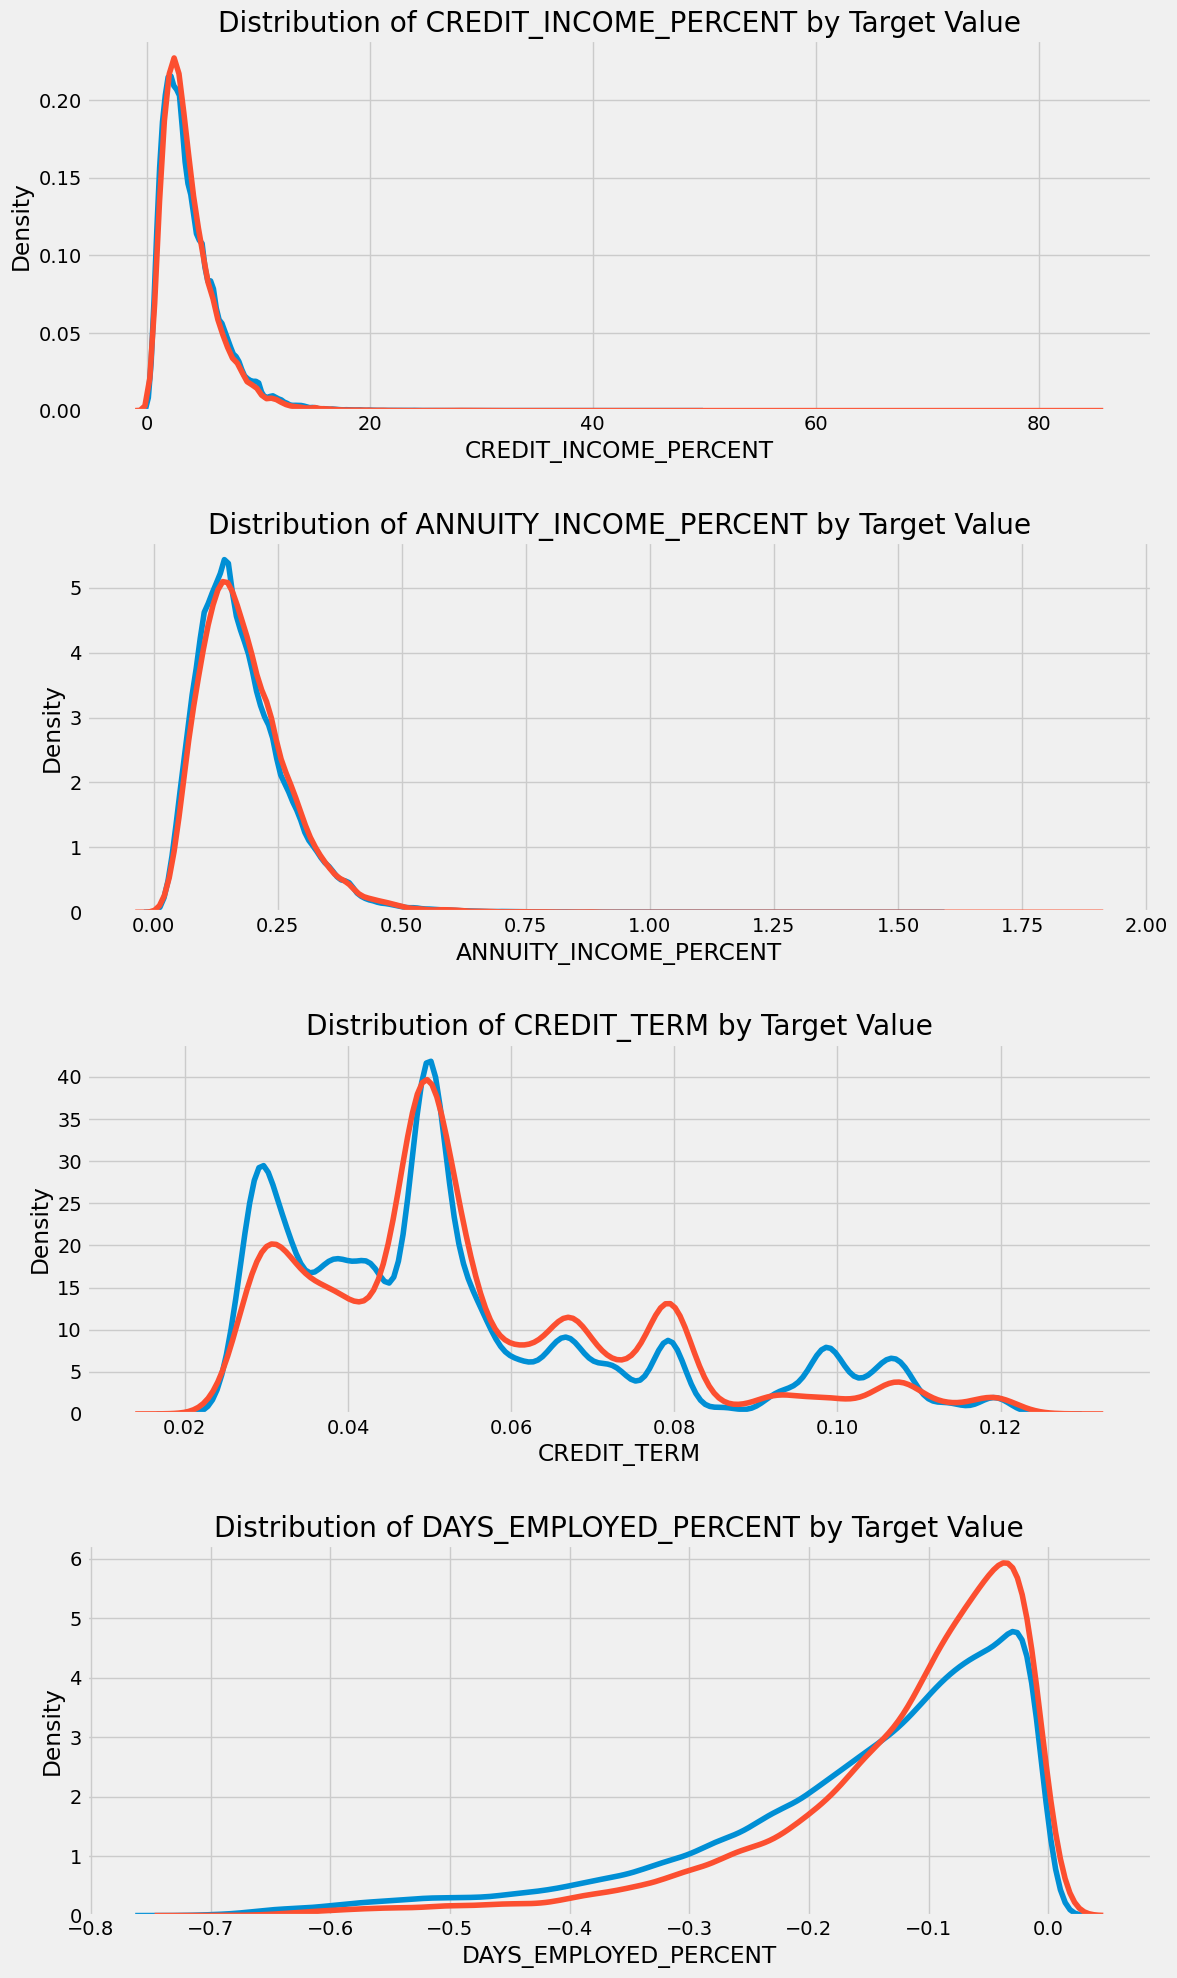

In [34]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Il est difficile de dire à l'avance si ces nouvelles fonctionnalités seront utiles. Le seul moyen d'en être sûr est de les essayer ! 

In [35]:
app_train_domain.to_csv('app_train_domain.csv', index=False)
app_test_domain.to_csv('app_test_domain.csv', index=False)


# 2 - Modélisation

In [36]:
# démarrage du tracking
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

### 2.1 - Split train en train/test

Je garde une copie du df intact avec les id clients et la target

In [37]:
app_train_origin=app_train_domain.copy()

In [38]:
ID = app_train_domain['SK_ID_CURR'] 
X = app_train_domain.drop(['SK_ID_CURR','TARGET'], axis=1)  
y = app_train_domain['TARGET']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 2.2 - Encoding Variables catégorielles

Un modèle d'apprentissage automatique ne peut pas traiter les variables catégorielles (à l'exception de certains modèles tels que LightGBM : http://lightgbm.readthedocs.io/en/latest/Features.html. 

Nous devons donc trouver un moyen d'encoder (représenter) ces variables sous forme de nombres avant de les transmettre au modèle. Il y a deux façons principales d'effectuer ce processus :
- Label encoding: attribue un nombre entier à chaque catégorie unique d'une variable catégorielle.
- One-hot encoding: créé une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne de la catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

Le problème du Label encoding est qu'il donne aux catégories un ordre arbitraire. La valeur attribuée à chacune des catégories est aléatoire et ne reflète aucun aspect inhérent à la catégorie. Dans l'exemple ci-dessus, le programmeur reçoit un 4 et le scientifique des données un 1, mais si nous refaisions le même processus, les étiquettes pourraient être inversées ou complètement différentes. L'affectation réelle des nombres entiers est arbitraire. Par conséquent, lorsque nous procédons à l'encodage des étiquettes, le modèle peut utiliser la valeur relative de la caractéristique (par exemple, programmeur = 4 et scientifique = 1) pour attribuer des poids, ce qui n'est pas ce que nous voulons. Si nous n'avons que deux valeurs uniques pour une variable catégorielle (telle que Homme/Femme), le Label Encoding convient, mais pour plus de deux catégories uniques, le One Hot Encoding est l'option la plus sûre.


Le seul inconvénient du One Hot Encoding est que le nombre de caractéristiques (dimensions des données) peut exploser avec des variables catégorielles comportant de nombreuses catégories. Pour y remédier, nous pouvons effectuer un OHE suivi d'une ACP ou d'autres méthodes de réduction de la dimensionnalité afin de réduire le nombre de dimensions tout en essayant de préserver l'information. 


Dans ce NB, nous utiliserons le Label Encoding pour toutes les variables catégorielles comportant seulement deux catégories et le OHE pour toutes les variables catégorielles comportant plus de deux catégories. Il se peut que ce processus doive être modifié au fur et à mesure que nous avançons dans le projet, mais pour l'instant, nous allons voir où cela nous mène. Nous n'utiliserons pas non plus de réduction de la dimensionnalité dans ce carnet, mais nous l'explorerons dans des itérations futures.

In [39]:
# Create a label encoder object
le = LabelEncoder()

# Iterate through the columns
le = LabelEncoder()
for col in X_train.columns:
    if X_train[col].dtype == 'object' and len(list(X_train[col].unique())) <= 2:
        # Apply the label encoder to both training and test sets
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


In [40]:
print('Training Features shape: ', X_train.shape)
print('Test Features shape: ', X_test.shape)

Training Features shape:  (246008, 125)
Test Features shape:  (61503, 125)


In [41]:
# Prétraitement : One-Hot Encoding pour les variables catégorielles
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

print('Training Features shape: ', X_train_ohe.shape)
print('Test Features shape: ', X_test_ohe.shape)


Training Features shape:  (246008, 246)
Test Features shape:  (61503, 246)


Il doit y avoir les mêmes colonnes dans le train et dans le test. Si le OHE a créé plus de colonnes dans le train que dans le test (parce qu'il y avait des variables catégorielles dont les catégories n'étaient pas représentées dans les données de test), alors il faut supprimer les colonnes des données d'apprentissage qui ne se trouvent pas dans les données de test. Pour ça, nous devons « aligner » les cadres de données. 

In [42]:
# Assurons-nous que X_train et X_test ont les mêmes colonnes
X_train_ohe, X_test_ohe = X_train_ohe.align(X_test_ohe, join='inner', axis=1)

print('Training Features shape: ', X_train_ohe.shape)
print('Val Features shape: ', X_test_ohe.shape)


Training Features shape:  (246008, 246)
Val Features shape:  (61503, 246)


Rmq : Lorsqu'on utilise la méthode align() avec l'option join='inner' pour aligner deux DataFrames pandas sur l'axe des colonnes, toutes les colonnes qui ne sont pas communes aux deux DataFrames sont supprimées du résultat final. Cela signifie que toute information contenue dans ces colonnes supprimées est perdue dans les DataFrames retournés par la méthode.

## 2.3 - Imputation MV et normalisation avec un min max scaler

Récupération des noms des colonnes avant imputation des MV et Standard Scaling pour extraire la feature importance après modélisation

In [43]:
from sklearn.preprocessing import MinMaxScaler

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))


X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_ohe), columns=X_train_ohe.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test_ohe), columns=X_test_ohe.columns)
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_imp.columns)
X_test_sc = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_imp.columns)



print('Training data shape: ', X_train_sc.shape)
print('Testing data shape: ', X_test_sc.shape)


Training data shape:  (246008, 246)
Testing data shape:  (61503, 246)


In [44]:
X_train_sc.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business En

## 2.4 - Baseline = Dummy Classifier

Pour obtenir une baseline :
- nous utiliserons toutes les caractéristiques après avoir encodé les variables catégorielles.
- Nous allons prétraiter les données en remplissant les valeurs manquantes (imputation)
- et normaliser les caractéristiques.


### 2.4.1 - Entrainement et prédictions

Pour avoir une référence et, comme le jeu de données est déséquilibré, on va tester un modèle naïf avec la stratégie 'stratified', qui va générer des prédictions en respectant la distribution des classes de l'ensemble d'entrainement

In [45]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

# Entraînement du Dummy Classifier
start_time=time.time()

dummy_clf.fit(X_train_sc, y_train)

end_time = time.time()
training_execution_time = round(end_time - start_time, 2)
print(f"Le temps d'entrainement est de {training_execution_time} secondes.")

Le temps d'entrainement est de 0.02 secondes.


Maintenant que le modèle a été entraîné, nous pouvons l'utiliser pour faire des prédictions. Nous voulons prédire les probabilités de ne pas rembourser un prêt, nous utilisons donc la méthode `predict.proba` du modèle. Celle-ci renvoie un tableau m x 2 où m est le nombre d'observations. La première colonne est la probabilité que la cible soit 0 et la deuxième colonne est la probabilité que la cible soit 1 (donc pour une seule ligne, la somme des deux colonnes doit être égale à 1). Nous voulons connaître la probabilité que le prêt ne soit pas remboursé, nous sélectionnerons donc la deuxième colonne.

Le code suivant effectue les prédictions et sélectionne la colonne correcte.

In [46]:
# Prédictions 
start_time=time.time()

y_pred_dummy_train = dummy_clf.predict(X_train_sc)
dummy_pred_train = dummy_clf.predict_proba(X_train_sc)[:, 1]

end_time = time.time()
predicting_execution_time = round(end_time - start_time, 2)
print(f"Le temps de prédiction sur le train est de {predicting_execution_time} secondes.")

y_pred_dummy_test = dummy_clf.predict(X_test_sc)
dummy_pred_test = dummy_clf.predict_proba(X_test_sc)[:, 1]


Le temps de prédiction sur le train est de 0.04 secondes.


### 2.4.2 - Evaluation

#### 2.4.2.1 - Confusion matrix et Classification Reports

In [47]:
pd.crosstab(y_test, y_pred_dummy_test, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
0,52008,4546
1,4576,373


In [48]:
print(classification_report(y_test, y_pred_dummy_test))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56554
           1       0.08      0.08      0.08      4949

    accuracy                           0.85     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.85      0.85     61503



#### 2.4.2.2 - AUC du train et du test

In [49]:
# Calculer l'AUC sur le train
auc_train = round(roc_auc_score(y_train, dummy_pred_train),2)
print("Train AUC:", auc_train)

Train AUC: 0.5


In [50]:
# Calculer l'AUC sur le test
auc_test = round(roc_auc_score(y_test, dummy_pred_test),2)
print("Test AUC:", auc_test)

Test AUC: 0.5


Avec ce modèle, on a 50% de chance que, en prenant 2 individus aléatoirement, l'individu le mieux scoré ait une target = 1.

### 2.4.3 - Elaboration du score métier

#### 2.4.3.1 - Définition de la matrice de coûts

- Faux Négatif (FN) : un mauvais client est prédit comme bon. Fixons ce coût à 10.
- Faux Positif (FP) : un bon client est prédit comme mauvais. Fixons ce coût à 1.

#### 2.4.3.2 - Calcul du coût total des erreurs

Pour chaque seuil de probabilité p utilisé pour classifier les observations en positives (clients défaillants) ou négatives (bons clients), on calcule le coût total des erreurs comme suit :
- on va calculer le nombre de FN et FP pour le seuil p
- on va calculer le coût total : coût total (p) = coût FN x Nbre FN + Coût FP x Nbre FP

In [51]:
# fonction qui va établir un seuil pour convertir les probabiliiéts en étiquettes de classe binaire. 
# à partir de la matrice de confusion, on va calculer le coût

def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    y_pred = (probas >= threshold).astype(int) # transforme les probas en prédictions binaires en utilisant un seuil. 
                                                # Les probabilités >= au seuil sont marquées comme 1 (positives),
                                                # les autres comme 0 (négatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() # .ravel() convertit la matrice 2x2 en un tableau à une dimension [tn, fp, fn, tp]
                                                            # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp

#### 2.4.3.3 - Optimisation du seuil

Il va s'agir d'utiliser une méthode pour trouver le seuil p qui minimise le Cout total.  
Cette étape peut impliquer :
- Analyse de la courbe des coûts : Tracage du coût total en fonction de différents seuils pour identifier visuellement le minimum.
- Recherche algorithmique :  Utilisation de techniques comme la recherche exhaustive dans un intervalle de seuils ou des méthodes plus sophistiquées comme l'optimisation numérique.

In [52]:
thresholds = np.linspace(0, 1, 100) # génére 100 valeurs de seuil uniformément réparties entre 0 et 1

costs = [calculate_cost_threshold(y_test, dummy_pred_test, thr, cost_fn=10, cost_fp=1) for thr in thresholds]


In [53]:
# on chrehce le seuil qui minimise le coût
optimal_threshold = round(thresholds[np.argmin(costs)],2) # détermine le seuil optimal en trouvant l'indice du coût minimal 
                                                        # dans la liste costs à l'aide de np.argmin(), 
                                                        # puis en récupérant la valeur correspondante dans thresholds. La valeur est arrondie à 2 décimales pour plus de lisibilité.
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.01


### 2.4.4 - Analyse des résultats du test au seuil optimal

#### 2.4.4.1 - Confusion matrix et Classification Reports au seuil optimal

In [54]:
y_pred_optimal = (dummy_pred_test >= optimal_threshold).astype(int)

Rmq : (dummy_pred_test >= optimal_threshold) effectue une comparaison élément par élément entre les probabilités prédites et le seuil optimal. Cela crée un tableau de booléens où chaque élément est True si la probabilité prédite est supérieure ou égale au seuil optimal, sinon False.
.astype(int) est utilisé pour convertir les valeurs booléennes (True/False) en entiers (1/0). Ainsi, les valeurs supérieures ou égales au seuil optimal seront converties en 1 et les autres en 0.
Le résultat final, y_pred_optimal, est un tableau de prédictions binaires où chaque élément est 1 si la probabilité prédite correspondante est supérieure ou égale au seuil optimal, sinon 0.

In [55]:
pd.crosstab(y_test, y_pred_optimal, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
0,52008,4546
1,4576,373


In [56]:
print(classification_report(y_test, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56554
           1       0.08      0.08      0.08      4949

    accuracy                           0.85     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.85      0.85     61503



#### 2.4.4.2 - recall et f1 score de la classe 1 au seuil optimal

In [57]:
report = classification_report(y_test, y_pred_optimal, output_dict=True) # output_dict=True indique à la fonction classification_report 
                                                    # de renvoyer le rapport sous forme de dictionnaire Python plutôt que sous forme de chaîne de caractères.

In [58]:
report

{'0': {'precision': 0.9191290824261276,
  'recall': 0.9196166495738586,
  'f1-score': 0.919372801357634,
  'support': 56554.0},
 '1': {'precision': 0.07582842041065257,
  'recall': 0.07536876136593251,
  'f1-score': 0.07559789217673288,
  'support': 4949.0},
 'accuracy': 0.8516820317708079,
 'macro avg': {'precision': 0.49747875141839004,
  'recall': 0.49749270546989555,
  'f1-score': 0.4974853467671834,
  'support': 61503.0},
 'weighted avg': {'precision': 0.851270685659879,
  'recall': 0.8516820317708079,
  'f1-score': 0.8514762430509452,
  'support': 61503.0}}

In [59]:
recall_1_test = round(report['1']['recall'],2)
print(f"Recall for class '1': {recall_1_test}")

Recall for class '1': 0.08


In [60]:
f1_score_1_test = round(report['1']['f1-score'],2)
print(f"F1 Score for class '1': {f1_score_1_test}")

F1 Score for class '1': 0.08


#### 2.4.4.3 - Accuracy du test au seuil optimal

In [61]:
accuracy_test = round(accuracy_score(y_test, y_pred_optimal),2)
print("Accuracy du test:", accuracy_test)

Accuracy du test: 0.85


### 2.4.5 - Enregistrement du modèle dans MLFlow

In [62]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     # mlflow.log_params(params)

#     # Log la métrique de perte que j'ai déclarée au dessus
    
#     mlflow.log_metric("optimal_threshold", optimal_threshold)

#     mlflow.log_metric("recall_1_test", recall_1_test)
#     mlflow.log_metric("f1_score_1_test", f1_score_1_test)
#     mlflow.log_metric("accuracy du test", accuracy_test)
    
#     mlflow.log_metric("auc_train", auc_train)
#     mlflow.log_metric("auc_test", auc_test)
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", predicting_execution_time)

    
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Dummy model _ Methode Stratified ")

#     # Infer the model signature
#     signature = infer_signature(X_train, dummy_clf.predict(X_train)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=dummy_clf, # le modèle
#         artifact_path="dummy_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=X_train, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-dummy", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


## 2.2 - Régression logistique 

### 2.2.1 - Définition des fonctions de scoring

In [63]:
def custom_f1(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_f1 = f1
            best_threshold = threshold
            best_cost = cost
    
    return best_f1

In [64]:


def custom_recall(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_recall = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_recall = recall
            best_threshold = threshold
            best_cost = cost
    
    return best_recall

### 2.2.2 - Entrainement

In [65]:
X_train_sc.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business En

In [66]:
# Fonction pour run la grid search. J'y ajoute le fit_params dans le quel j'ajouterai l'early stopping pour le lgbm

def run_grid_search(X_train, y_train, model, param_grid, fit_params=None, train_size=1.0):
    # Définir les scorers personnalisés
    scorers = {
        'AUC': 'roc_auc',
        'F1_opt': make_scorer(custom_f1, needs_proba=True),
        'recall_opt': make_scorer(custom_recall, needs_proba=True)
    }

    # Créer un pipeline avec SMOTE et le modèle
    pipeline = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Mettre à jour le param_grid pour correspondre au pipeline
    # Les paramètres du modèle doivent être préfixés par 'model__'
    param_grid = {f'model__{key}': value for key, value in param_grid.items()}

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='AUC',
        cv=2,
        verbose=3,
        return_train_score=True
    )

     # Fractionnement des données si train_size < 1.0
    if train_size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        data_to_fit = (X_train_sample, y_train_sample)
    else:
        data_to_fit = (X_train, y_train)

    # Entraînement
    start_time = time.time()
    grid_search.fit(*data_to_fit)
    end_time = time.time()

    execution_time = round(end_time - start_time, 2)
    print(f"Le temps d'execution est de {execution_time} secondes.")

    return {
        'best_model' : grid_search.best_estimator_,
        'best_params_': grid_search.best_params_,
        'best_score_': grid_search.best_score_,
        'cv_results_': grid_search.cv_results_
    }

In [67]:
# Configuration du modèle
model_logit = LogisticRegression(
    solver='saga', 
    class_weight = 'balanced',
    random_state=42
)
model_logit

LogisticRegression(class_weight='balanced', random_state=42, solver='saga')

In [68]:
# Paramètres à passer au Grid Search
param_grid_logit = {
    'C': np.logspace(-4, 4, 2),
    'penalty': ['l1', 'l2']

}
param_grid_logit

{'C': array([1.e-04, 1.e+04]), 'penalty': ['l1', 'l2']}

Notes :  

1. **solver='saga'**
Le paramètre solver spécifie l'algorithme à utiliser pour l'optimisation des poids du modèle dans le processus d'apprentissage. saga est une variante de l'algorithme de descente de gradient stochastique qui est bien adaptée pour les grands jeux de données, car elle est efficace en termes de mémoire et supporte les deux types de régularisation L1 ((pour la sélection de caractéristiques) et L2 (pour éviter le surajustement)

2. **max_iter=10000**
Le paramètre max_iter définit le nombre maximal d'itérations que l'algorithme de résolution peut exécuter pour atteindre la convergence. Une valeur élevée comme 10000 assure que l'algorithme a suffisamment de temps pour converger, particulièrement utile dans des scénarios où le modèle a du mal à converger ou lorsque le jeu de données est complexe ou très grand.
Augmenter max_iter permet à l'algorithme plus d'itérations pour trouver les poids optimaux, réduisant ainsi le risque d'arrêter l'apprentissage trop tôt avant que le modèle n'atteigne la stabilité. Bien que permettre plus d'itérations puisse améliorer la précision du modèle, cela peut également augmenter le temps de calcul. Il est donc important de trouver un équilibre entre le nombre d'itérations et les ressources de calcul disponibles.

3. **'F2': make_scorer(fbeta_score, beta=2)**.fbeta_score : Utilise la fonction fbeta_score, qui est une généralisation du F1-score. Le F1-score est en fait un fbeta_score avec beta=1.
beta=2 : Le paramètre beta ajuste l'importance relative du rappel par rapport à la précision. Un beta de 2 donne deux fois plus d'importance au rappel qu'à la précision. Cela peut être utile dans des situations où il est plus critique de minimiser les faux négatifs que les faux positifs.5.


In [69]:
# X_train_original = X_train_sc.copy()

In [70]:
# Execution de la fonction
start_training_time = time.time()
results_logit = run_grid_search(X_train_sc, y_train, model_logit, param_grid_logit, train_size=1)
end_training_time = time.time()


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__C=0.0001, model__penalty=l1; AUC: (train=0.500, test=0.500) F1_opt: (train=0.000, test=0.000) recall_opt: (train=0.000, test=0.000) total time=  16.2s
[CV 2/2] END model__C=0.0001, model__penalty=l1; AUC: (train=0.500, test=0.500) F1_opt: (train=0.000, test=0.000) recall_opt: (train=0.000, test=0.000) total time=  11.7s
[CV 1/2] END model__C=0.0001, model__penalty=l2; AUC: (train=0.703, test=0.695) F1_opt: (train=0.236, test=0.233) recall_opt: (train=0.591, test=0.581) total time=  22.3s
[CV 2/2] END model__C=0.0001, model__penalty=l2; AUC: (train=0.701, test=0.704) F1_opt: (train=0.236, test=0.242) recall_opt: (train=0.583, test=0.553) total time=  25.3s
[CV 1/2] END model__C=10000.0, model__penalty=l1; AUC: (train=0.744, test=0.735) F1_opt: (train=0.261, test=0.264) recall_opt: (train=0.666, test=0.618) total time= 1.6min
[CV 2/2] END model__C=10000.0, model__penalty=l1; AUC: (train=0.742, test=0.736) F1_o

In [71]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 542.6 secondes.


In [72]:
# # Vérification du X_train Post-entraînement
# print("Vérification des modifications dans X_train:", (X_train_original == X_train_sc).all().all())

In [73]:
best_model_logit = results_logit['best_model']
best_params_logit = results_logit['best_params_']
best_score_logit = results_logit['best_score_']
cv_results_logit = results_logit['cv_results_']


print("Best Params:", best_params_logit)
print("Best AUC:", best_score_logit)


Best Params: {'model__C': 10000.0, 'model__penalty': 'l1'}
Best AUC: 0.7353509194609393


### 2.2.3 - Analyse de la cross_validation

In [74]:
def extract_best_auc_result(results):
    """
    Extracts the best model configuration based on AUC score from the cv_results of a GridSearchCV.
    
    Parameters:
    - results (dict): A dictionary output from the run_grid_search function containing 'cv_results_'.
    
    Returns:
    - DataFrame: A DataFrame containing the best scoring row based on the AUC rank.
    """
    # Conversion of cv_results_ into a DataFrame
    cv_results = results['cv_results_']
    df_cv_results = pd.DataFrame(cv_results)
    
    # Sorting the DataFrame by the rank of the AUC test scores
    df_cv_results = df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
    
    # Returning the top entry
    return df_cv_results.head(1)

In [75]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [76]:
best_auc_result = extract_best_auc_result(results_logit)
best_auc_result.head(1)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,params,split0_test_AUC,split1_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,mean_train_AUC,std_train_AUC,split0_test_F1_opt,split1_test_F1_opt,mean_test_F1_opt,std_test_F1_opt,rank_test_F1_opt,split0_train_F1_opt,split1_train_F1_opt,mean_train_F1_opt,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
2,75.298046,12.609549,6.574747,0.667539,10000.0,l1,"{'model__C': 10000.0, 'model__penalty': 'l1'}",0.735048,0.735654,0.735351,0.000303,1,0.743917,0.742272,0.743094,0.000822,0.264317,0.254171,0.259244,0.005073,1,0.261105,0.269623,0.265364,0.004259,0.617931,0.663715,0.640823,0.022892,1,0.665728,0.624572,0.64515,0.020578


La meilleure combinaison d'hyperparamètres est déterminée en maximisant le F1 score, grâce au paramètre refit='F1_opt' de GridSearchCV. Les autres métriques sont calculées pour fournir une évaluation complète des performances du modèle, mais elles ne sont pas utilisées pour le choix final des hyperparamètres.

In [77]:
# Les résultats de la combinaison la mieux classée
best_auc_result.iloc[0]

mean_fit_time                                                  75.298046
std_fit_time                                                   12.609549
mean_score_time                                                 6.574747
std_score_time                                                  0.667539
param_model__C                                                   10000.0
param_model__penalty                                                  l1
params                     {'model__C': 10000.0, 'model__penalty': 'l1'}
split0_test_AUC                                                 0.735048
split1_test_AUC                                                 0.735654
mean_test_AUC                                                   0.735351
std_test_AUC                                                    0.000303
rank_test_AUC                                                          1
split0_train_AUC                                                0.743917
split1_train_AUC                                   

On obtient une ligne par combinaison de variables :
- **'mean_fit_time'** et **'std_fit_time'** : Temps moyen et écart-type du temps d'ajustement, respectivement, à travers toutes les folds et les combinaisons de paramètres.  
- **'mean_score_time'** et **'std_score_time'** : Temps moyen et écart-type du temps d'évaluation, respectivement, à travers toutes les folds et les combinaisons de paramètres.
  
- **'param_C'** et **'param_penalty'** etc.. : Les valeurs des hyperparamètres pour chaque combinaison.  
- **'params'** : Liste de dictionnaires représentant les combinaisons de paramètres.
  
- **'split0_test_AUC'**, **'split1_test_AUC'**, ...,  : AUC du test pour chaque fold.  
- **'mean_test_AUC'** et **'std_test_AUC'** : Moyenne et écart-type des AUC à travers toutes les folds pour chaque combinaison de paramètres.  
- **'rank_test_AUC'** : Le classement de chaque combinaison de paramètres basé sur la moyenne des AUC.  


Etc...


=> Dans notre exemple, c'est la combinaison :
{'C': 0.3593813663804626, 'penalty': 'l2'}	
 qui a obtenu la meilleure AUC, comme indiqué par le rang 1 dans les deux cas.

In [78]:
def plot_auc_scores(best_auc_result):
    """
    Plots the AUC scores from cross-validation folds for the best model configuration based on rank.
    
    Parameters:
    - best_auc_result (DataFrame): A DataFrame with the top row from cv_results_ sorted by AUC.
    - full_cv_results (DataFrame): The full cv_results DataFrame to extract mean scores for rank 1.
    """
    # Extract the AUC scores for each fold for the best AUC configuration
    df_train_results_auc = best_auc_result[[
        'split0_train_AUC', 
        'split1_train_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    df_test_results_auc = best_auc_result[[
        'split0_test_AUC', 
        'split1_test_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot the train scores
    ax.plot(range(0, 2), df_test_results_auc.reshape(-1), label='Scores de validation')
    
    # Plot the test scores
    ax.plot(range(0, 2), df_train_results_auc.reshape(-1), label='Scores de train')

    # # Plot the average for the combinations with rank_test_AUC == 1
    # mean_scores_rank_1 = best_auc_result.loc[best_auc_result['rank_test_AUC'] == 1, 'mean_test_AUC']
    # ax.axhline(y=mean_scores_rank_1.values[0], color='g', linestyle='--', label='Moyenne (rank 1)')
    
    # Set the properties of the axis
    ax.set_xticks(range(0, 2))
    ax.set_xlabel("Folds de cross-validation")
    ax.set_ylabel('AUC')
    ax.set_title("AUC de chaque fold \n pour la combinaison d'hyperparamètres \n qui arrive au rang 1 en terme d'AUC", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
    
    # Add a legend
    ax.legend()

    fig.tight_layout()
    
    plt.show()


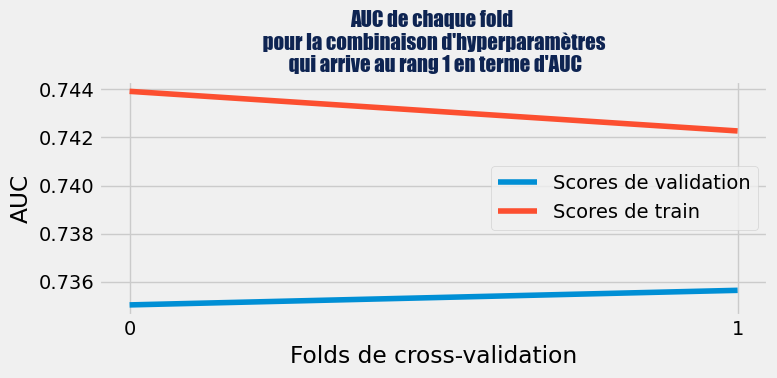

In [79]:
plot_auc_scores(best_auc_result)

### 2.2.4 - Prédictions et métriques d'évaluation

In [80]:
def evaluate_model (X_train, y_train, X_test, y_test, best_model):

    start_predict_time = time.time()
    # Predict on the training data
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    
    # Predict on the test data
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    end_predict_time = time.time()

    # Calculate AUC for training and test data
    auc_train = round(roc_auc_score(y_train, y_train_pred_proba),2)
    auc_test = round(roc_auc_score(y_test, y_test_pred_proba),2)

    # Find the optimal threshold for cost function on the training data
    thresholds = np.linspace(0, 1, 100)
    costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
    optimal_threshold = round(thresholds[np.argmin(costs)],2) 

    # Metrics at the optimal threshold
    y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
    
    f1_score_1_test = f1_score(y_test, y_test_pred_opt)
    recall_1_test = recall_score(y_test, y_test_pred_opt)
    accuracy_test = accuracy_score(y_test, y_test_pred_opt)
    
    return {
        'predicting_execution_time': round(end_predict_time - start_predict_time, 2),
        'auc_train': auc_train,
        'auc_test': auc_test,
        'optimal_threshold': optimal_threshold,
        'f1_score_1_test': round(f1_score_1_test,2),
        'recall_1_test': round(recall_1_test,2),
        'accuracy_test': round(accuracy_test,2)
    }

In [81]:
result_logit=evaluate_model (X_train_sc, y_train, X_test_sc, y_test, best_model_logit)
result_logit

{'predicting_execution_time': 0.22,
 'auc_train': 0.74,
 'auc_test': 0.74,
 'optimal_threshold': 0.52,
 'f1_score_1_test': 0.26,
 'recall_1_test': 0.63,
 'accuracy_test': 0.72}

### 2.2.5 - Enregistrement du modèle dans ML Flow

In [ ]:
# Utiliser un échantillon de 10 lignes comme exemple d'entrée
input_example = X_train_sc.sample(n=10, random_state=42)

In [82]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_logit)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_logit['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_logit['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_logit['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_logit['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_logit['auc_train'])
#     mlflow.log_metric("auc_test", result_logit['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_logit['predicting_execution_time'])

    
 
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Logistic Regression with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, best_model_logit.predict(X_train_sc)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_logit.named_steps['model'], # le modèle
#         artifact_path="logistic_regression_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-logistic-regression", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


### 2.4.6 - Feature Importance

In [83]:
importances = best_model_logit.named_steps['model'].coef_
importances = importances.flatten()

In [84]:
feature_importances = pd.DataFrame({
    'feature': X_train_sc.columns, 
    'importance': importances
})

In [85]:
feature_importances_sorted=feature_importances.sort_values(by='importance', ascending=False).reset_index()
feature_importances_sorted=feature_importances_sorted.head(10)

In [86]:
feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()

In [87]:
feature_importances_sorted

,index,feature,importance,importance_normalized
0,4,AMT_INCOME_TOTAL,10.059570,0.195222
1,5,AMT_CREDIT,7.702810,0.149485
2,51,COMMONAREA_MODE,5.573271,0.108158
3,77,DEF_30_CNT_SOCIAL_CIRCLE,5.544484,0.107600
4,109,ANNUITY_INCOME_PERCENT,4.849580,0.094114
5,81,FLAG_DOCUMENT_2,4.658984,0.090415
6,71,LIVINGAPARTMENTS_MEDI,3.675034,0.071320
7,62,BASEMENTAREA_MEDI,3.249750,0.063067
8,6,AMT_ANNUITY,3.181302,0.061738
9,35,YEARS_BEGINEXPLUATATION_AVG,3.034058,0.058881


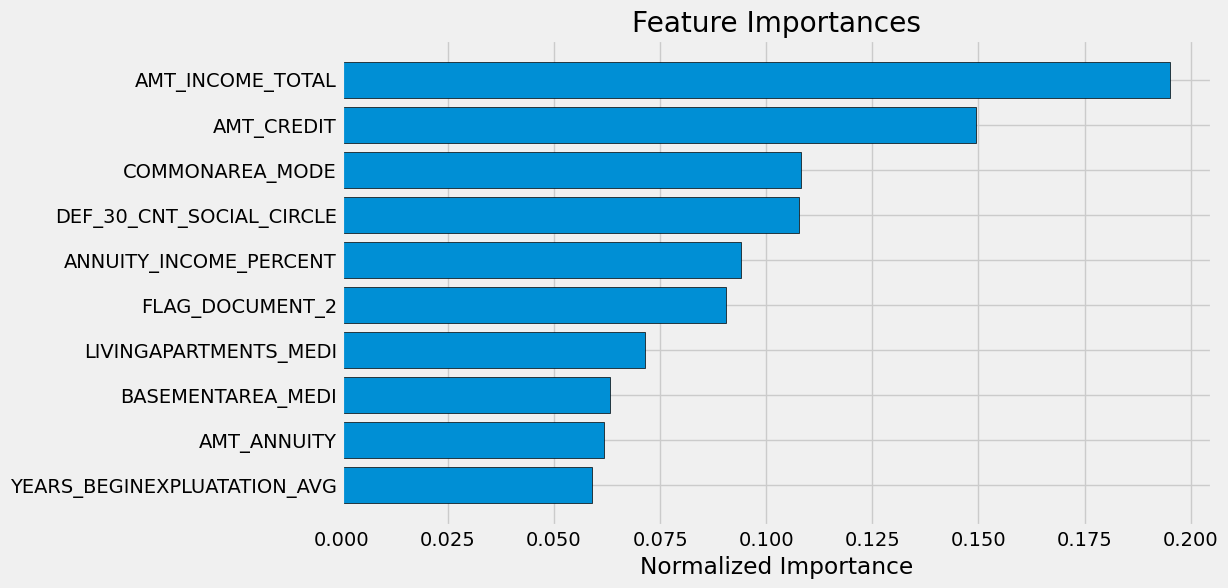

In [88]:
# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances_sorted.index[:15]))), 
feature_importances_sorted['importance_normalized'].head(15), 
align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances_sorted.index[:15]))))
ax.set_yticklabels(feature_importances_sorted['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

Les 5 premières variables :
- 'AMT_INCOME_TOTAL'	= Revenus du client
- 'AMT_CREDIT' =	Montant du prêt
- 'COMMONAREA_MODE' = Informations normalisées sur l'immeuble où vit le client : taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, surface commune, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées, état de l'immeuble, nombre d'étages, etc.
- 'DEF_30_CNT_SOCIAL_CIRCLE' = Cette phrase interroge sur le nombre d'occasions où les entourages sociaux du client ont été enregistrés comme ayant un retard de paiement exactement de 30 jours après la date d'échéance.
- 'ANNUITY_INCOME_PERCENT' = le pourcentage de la mensualité du prêt par rapport au revenu du client

## 2.3 - Random Forest

###  2.3.1 - Entrainement

In [89]:
model_RF = RandomForestClassifier(random_state = 50, 
                                  class_weight='balanced')
param_grid_RF = {
   'n_estimators': [120,150],  
   'max_depth': [7,8],
   # 'max_features': [0.0],
   # 'min_samples_leaf': [0.01,0.05],
   # 'min_samples_split': [0.03,0.05]
    
}

In [90]:
# Execution de la fonction
start_training_time = time.time()

results_RF = run_grid_search(X_train_sc, y_train, model_RF, param_grid_RF)

end_training_time = time.time()

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__max_depth=7, model__n_estimators=120; AUC: (train=0.680, test=0.669) F1_opt: (train=0.218, test=0.214) recall_opt: (train=0.615, test=0.603) total time=  52.5s
[CV 2/2] END model__max_depth=7, model__n_estimators=120; AUC: (train=0.685, test=0.665) F1_opt: (train=0.221, test=0.211) recall_opt: (train=0.610, test=0.585) total time=  44.3s
[CV 1/2] END model__max_depth=7, model__n_estimators=150; AUC: (train=0.681, test=0.669) F1_opt: (train=0.219, test=0.214) recall_opt: (train=0.616, test=0.603) total time= 1.1min
[CV 2/2] END model__max_depth=7, model__n_estimators=150; AUC: (train=0.685, test=0.665) F1_opt: (train=0.224, test=0.211) recall_opt: (train=0.580, test=0.587) total time=  53.6s
[CV 1/2] END model__max_depth=8, model__n_estimators=120; AUC: (train=0.694, test=0.673) F1_opt: (train=0.220, test=0.216) recall_opt: (train=0.686, test=0.596) total time=  51.4s
[CV 2/2] END model__max_depth=8, model__n

In [91]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 646.4 secondes.


In [92]:
best_model_RF = results_RF['best_model']
best_params_RF = results_RF['best_params_']
best_score_RF = results_RF['best_score_']
cv_results_RF = results_RF['cv_results_']

print("Best Params:", best_params_RF)
print("Best AUC:", best_score_RF)

Best Params: {'model__max_depth': 8, 'model__n_estimators': 150}
Best AUC: 0.6709266352736621


###  2.3.2 - Analyse de la cross_validation

In [93]:
best_auc_result_RF = extract_best_auc_result(results_RF)
best_auc_result_RF.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,split0_test_AUC,split1_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,mean_train_AUC,std_train_AUC,split0_test_F1_opt,split1_test_F1_opt,mean_test_F1_opt,std_test_F1_opt,rank_test_F1_opt,split0_train_F1_opt,split1_train_F1_opt,mean_train_F1_opt,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
3,63.065038,2.634566,7.071438,0.351778,8,150,"{'model__max_depth': 8, 'model__n_estimators':...",0.672945,0.668908,0.670927,0.002019,1,0.694481,0.697068,0.695775,0.001294,0.216222,0.216595,0.216409,0.000187,1,0.223506,0.225979,0.224743,0.001236,0.598712,0.553029,0.57587,0.022842,4,0.657778,0.649024,0.653401,0.004377


In [94]:
# Les résultats de la combinaison la mieux classée
best_auc_result_RF.iloc[0]

mean_fit_time                                                        63.065038
std_fit_time                                                          2.634566
mean_score_time                                                       7.071438
std_score_time                                                        0.351778
param_model__max_depth                                                       8
param_model__n_estimators                                                  150
params                       {'model__max_depth': 8, 'model__n_estimators':...
split0_test_AUC                                                       0.672945
split1_test_AUC                                                       0.668908
mean_test_AUC                                                         0.670927
std_test_AUC                                                          0.002019
rank_test_AUC                                                                1
split0_train_AUC                                    

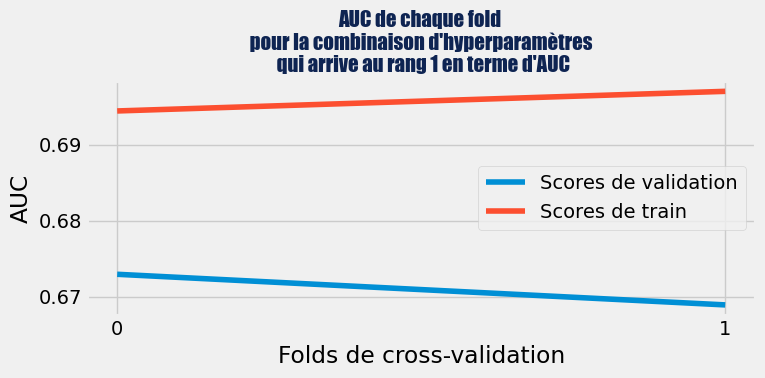

In [95]:
plot_auc_scores(best_auc_result_RF)

###  2.3.3 - Prédictions et métriques d'évaluation

In [96]:
result_RF=evaluate_model(X_train_sc, y_train, X_test_sc, y_test, best_model_RF)
result_RF

{'predicting_execution_time': 3.83,
 'auc_train': 0.68,
 'auc_test': 0.67,
 'optimal_threshold': 0.4,
 'f1_score_1_test': 0.21,
 'recall_1_test': 0.58,
 'accuracy_test': 0.66}

### 2.3.4 - Enregistrement dans ML Flow

In [97]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_RF)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_RF['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_RF['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_RF['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_RF['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_RF['auc_train'])
#     mlflow.log_metric("auc_test", result_RF['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_RF['predicting_execution_time'])

    
 
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Random forest Classifier with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train, best_model_RF.predict(X_train)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_RF.named_steps['model'], # le modèle
#         artifact_path="random_forest_classifier_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-random-forest_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


### 2.3.5 - Feature Importance

In [98]:
importances = best_model_RF.named_steps['model'].feature_importances_
features= X_train_sc.columns

In [99]:
def show_feature_importances(importances, features):
    # Création du DataFrame

    importances = importances.flatten()
    
    feature_importances = pd.DataFrame({
        'feature': features, 
        'importance': importances
    })
    
    # Tri et sélection des 10 caractéristiques les plus importantes
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importances_sorted = feature_importances_sorted.head(10)
    
    # Normalisation des importances
    feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()
    
    # Création du graphique à barres horizontales
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Inversion de l'index pour afficher la plus importante en haut
    indices = list(reversed(list(feature_importances_sorted.index)))
    ax.barh(indices, feature_importances_sorted['importance_normalized'], align='center', edgecolor='k')
    
    # Définition des étiquettes y
    ax.set_yticks(indices)
    ax.set_yticklabels(feature_importances_sorted['feature'])
    
    # Étiquetage du graphique
    plt.xlabel('Normalized Importance')
    plt.title('Top 10 Feature Importances')
    plt.show()
    
    return feature_importances_sorted

# Exemple d'utilisation
# importances = [valeur1, valeur2, ..., valeurN] # remplacez par vos valeurs d'importance réelles
# features = ['nom1', 'nom2', ..., 'nomN'] # remplacez par vos noms de caractéristiques réels
# feature_importances_sorted = plot_feature_importances(importances, features)


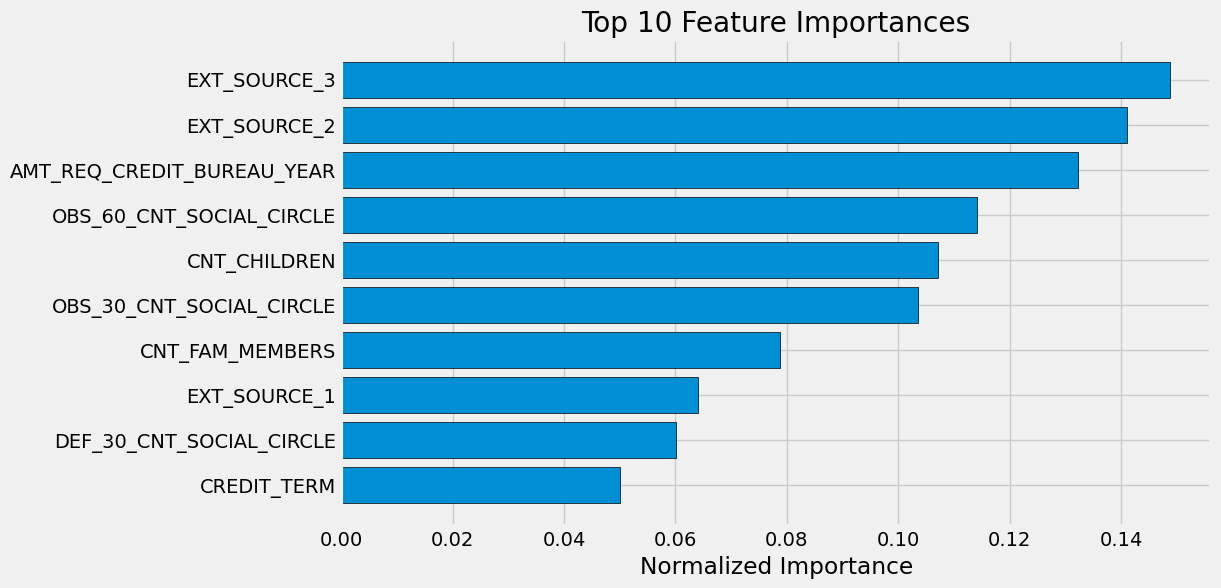

,feature,importance,importance_normalized
0,EXT_SOURCE_3,0.089763,0.148740
1,EXT_SOURCE_2,0.085075,0.140971
2,AMT_REQ_CREDIT_BUREAU_YEAR,0.079867,0.132342
3,OBS_60_CNT_SOCIAL_CIRCLE,0.068911,0.114187
4,CNT_CHILDREN,0.064704,0.107216
5,OBS_30_CNT_SOCIAL_CIRCLE,0.062466,0.103509
6,CNT_FAM_MEMBERS,0.047583,0.078847
7,EXT_SOURCE_1,0.038702,0.064129
8,DEF_30_CNT_SOCIAL_CIRCLE,0.036233,0.060039
9,CREDIT_TERM,0.030186,0.050019


In [100]:
show_feature_importances(importances, features)

Les variables les+ influentes :
- 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1'	 : Les variables de score normalisé provenant d'une source de données externe sont présentes dans le top 8 des variables les plus influentes
- 'AMT_REQ_CREDIT_BUREAU_YEAR' : Nombre de demandes de renseignements au bureau de crédit concernant le client xxx temps avant la demande (à l'exclusion de XXXX avant la demande)
- 'OBS_60_CNT_SOCIAL_CIRCLE' et 'OBS_30_CNT_SOCIAL_CIRCLE' : Cette phrase cherche à quantifier le nombre d'observations où l'on peut constater que les entourages sociaux du client ont des défauts de paiement dépassant 60 jours et 30 jours après l'échéance prévue.
- 'CNT_CHILDREN' : Nbre d'enfants

Les variables qui ont le plus de poids dans le Random Forest sont très différentes de la Regression logistique

## 2.4 - Light Gradient Boosting Machine

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/ 
The LightGBM library : http://lightgbm.readthedocs.io/en/latest/Quick-Start.html

LightGBM est un framework d'apprentissage automatique développé par Microsoft, qui est largement utilisé pour les tâches de classification, de régression et de classement. Il appartient à la catégorie des algorithmes de boosting basés sur des arbres de décision, similaire à XGBoost et CatBoost. Voici quelques points clés pour comprendre LightGBM :

LightGBM utilise le gradient boosting, une technique qui construit de manière itérative des modèles de prévision en ajoutant des arbres de décision faibles, chaque nouvel arbre étant construit pour corriger les erreurs des arbres précédents. Ces arbres sont ajoutés séquentiellement jusqu'à ce qu'un nombre spécifié d'arbres soit atteint ou que les améliorations deviennent négligeables.

**Son fonctionnement** :
1. Initialisation 
- LightGBM commence par créer un modèle initial très simple, souvent appelé "base learner". Ce modèle peut être quelque chose d’aussi simple qu’une régression ou un arbre de décision très basique. L'idée est de créer un point de départ pour l'algorithme.
- Ce premier modèle fait une prédiction basique qui est généralement loin d'être parfaite mais fournit une base sur laquelle construire.
2. Apprendre des Erreurs
- Après avoir fait ses premières prédictions, LightGBM examine les erreurs — les différences entre les valeurs prédites et les valeurs réelles. Ces erreurs sont aussi appelées résidus.
- Un nouveau modèle est ensuite entraîné, mais au lieu de prédire la valeur cible originale, il essaie de prédire ces résidus (les erreurs du premier modèle). L’idée est de corriger là où le premier modèle s’est trompé.
3. Répéter
- Ce processus de correction des erreurs en entraînant un nouveau modèle sur les résidus est répété plusieurs fois. Chaque nouveau modèle est conçu pour améliorer les prédictions là où les modèles précédents ont échoué.
- À chaque étape, l’algorithme se concentre de plus en plus sur les cas les plus difficiles à prédire, raffinant progressivement sa capacité à modéliser les données de manière précise.
4. Combiner
- Tous les modèles simples créés lors des différentes itérations sont combinés pour former le modèle final. Chaque modèle individuel apporte sa contribution spécifique, aidant à prédire une partie différente du problème.
- Dans LightGBM, comme dans d'autres algorithmes de boosting, les contributions de chaque modèle peuvent être pondérées pour optimiser les performances globales. Certains modèles peuvent se voir attribuer plus d'importance en fonction de leur précision.

**Particularités du LightGBM**
- Contrairement à d'autres algorithmes qui construisent des arbres en se développant niveau par niveau, LightGBM utilise une stratégie de croissance par feuilles. Dans cette approche, plutôt que d'ajouter une rangée complète de branches, vous ajoutez la branche la plus nécessaire ou la plus "utile" à chaque étape, indépendamment du niveau. Cela permet de se concentrer plus intensément sur les parties de l'arbre qui réduiront le plus rapidement l'erreur globale. Cela permet souvent de réduire plus rapidement l'erreur globale, bien que le risque de surajustement puisse être légèrement plus élevé, surtout avec des ensembles de données plus petits.
- LightGBM utilise des techniques telles que le partage basé sur des histogrammes pour accélérer l'entraînement. Au lieu de regarder chaque point de donnée unique, il regroupe les valeurs en "bacs" (comme les barres d'un histogramme), et ces bacs sont utilisés pour trouver le meilleur endroit pour diviser les données. Cette méthode réduit considérablement le nombre de calculs nécessaires, car il y a moins de points de division à considérer. Cela rend l'algorithme beaucoup plus rapide et moins gourmand en mémoire, particulièrement avantageux quand on travaille avec de grands ensembles de données.

En résumé, LightGBB utilise une série de modèles qui apprennent progressivement des erreurs des modèles précédents, chacun ajoutant sa propre correction jusqu'à ce qu'un modèle final complet et précis soit formé. C'est une méthode puissante car elle transforme de nombreux apprenants faibles en un prédicteur fort et fiable.

**Avantages** :
- Vitesse et efficacité : L'une des principales forces de LightGBM est sa vitesse d'entraînement rapide et son utilisation efficace de la mémoire.
- Prise en charge des données catégorielles : LightGBM peut gérer directement les caractéristiques catégorielles sans nécessiter de codage préalable, ce qui est une différence significative par rapport à d'autres algorithmes de boosting.
- Facilité d'utilisation et flexibilité : Il est facile à configurer avec une large gamme de paramètres ajustables pour optimiser les performances du modèle.
  
**Applications** :
- LightGBM est utilisé dans une variété de domaines allant de la prédiction de risques financiers à la détection de fraudes, en passant par les recommandations de produits et la prédiction de demandes. Sa capacité à fournir des résultats rapides et précis avec des ensembles de données volumineux le rend particulièrement précieux dans les environnements où les performances et la vitesse sont critiques.



**Quelle différence avec XGboost ?**
LightGBM et XGBoost sont deux des frameworks les plus populaires pour le boosting d'arbres de décision, mais ils présentent des différences clés en termes de méthodologie, d'optimisation, et d'applications typiques. Voici une comparaison des deux, ainsi que les détails sur leur apparition :

XGBoost (eXtreme Gradient Boosting)
Apparition: XGBoost a été développé par Tianqi Chen dans le cadre d'un projet de recherche à l'Université de Washington et a été rendu public en 2014. Il a rapidement gagné en popularité en raison de sa performance dans de nombreuses compétitions de machine learning.

Caractéristiques:
- Utilise un modèle de boosting de gradient, construisant des arbres de manière séquentielle.
- Employe un algorithme basé sur le pré-partitionnement des données en structure de bloc pour gérer les grands ensembles de données de manière plus efficace.
- Propose des régularisations (L1 et L2) pour prévenir le surajustement.
- Utilise la croissance par niveaux des arbres (level-wise), qui équilibre mieux la croissance des arbres mais peut être moins efficace en termes de réduction de l'erreur par rapport à la croissance par feuilles.

LightGBM
Apparition: LightGBM a été développé par Microsoft et introduit en janvier 2017. Il a été conçu pour surmonter certaines des limitations de vitesse et d'échelle de XGBoost et d'autres algorithmes de boosting.

Caractéristiques:
- Utilise également le boosting de gradient mais incorpore plusieurs optimisations pour la vitesse et l'efficacité, comme le partage basé sur des histogrammes.
- Utilise la croissance par feuilles (leaf-wise) qui peut réduire l'erreur plus rapidement mais risque le surajustement sur des petits ensembles de données.
- Gère efficacement les données catégorielles sans prétraitement.
- Optimisé pour la performance en vitesse et en utilisation de mémoire, particulièrement sur des ensembles de données de grande taille.

Différences Clés
- Méthode de construction des arbres : XGBoost construit les arbres niveau par niveau tandis que LightGBM le fait feuille par feuille.
- Gestion des caractéristiques catégorielles : LightGBM peut gérer directement les caractéristiques catégorielles, alors que XGBoost nécessite généralement un prétraitement comme le one-hot encoding.
- Efficacité et vitesse : LightGBM est généralement plus rapide qu'XGBoost, en particulier sur des ensembles de données très grands ou avec de nombreuses caractéristiques, en raison de ses optimisations spécifiques.

Choix entre les deux
Le choix entre XGBoost et LightGBM dépend souvent de la taille de l'ensemble de données et des ressources disponibles :
- XGBoost peut être préférable pour des ensembles de données de taille modérée ou lorsque la prévention du surajustement est critique.
- LightGBM est souvent le choix pour des ensembles de données très volumineux ou pour des applications nécessitant une grande efficacité de calcul.

Dans l'ensemble, les deux frameworks sont hautement performants et le choix entre eux peut aussi dépendre de la familiarité et des préférences personnelles des utilisateurs en matière d'outils d'apprentissage automatique.

### 2.4.1 - Entrainement

In [101]:
from lightgbm import early_stopping

model_LGBM = lgb.LGBMClassifier(objective='binary', # spécifie que le modèle est utilisé pour une classification binaire
                                boosting_type = 'goss',# boosting_type détermine l'algorithme de boosting à utiliser. 
                                                   # GOSS signifie Gradient-based One-Side Sampling. 
                                                   # GOSS est une méthode avancée qui améliore l'efficacité du modèle en conservant toutes les instances
                                                   # avec des gradients importants (ceux qui sont mal prédits) 
                                                   # et en sous-échantillonnant de manière aléatoire les instances avec des gradients faibles 
                                                   # (ceux qui sont bien prédits). 
                                                   # Cette technique permet de réduire la quantité de données tout en conservant 
                                                   # les informations les plus utiles pour l'apprentissage, 
                                                   # accélérant ainsi la formation sans perte significative de précision.

                                class_weight='balanced',
                                random_state = 50)
        
param_grid_LGBM = {
    'num_leaves': [20,25],
    # 'learning_rate' : [0.01,0.1], 
    'n_estimators': [100,200]
}

# Paramètres pour early_stopping
fit_params = {
    'eval_metric': 'auc',
    'callbacks':[early_stopping(stopping_rounds=50)]
}

- num_leaves : définit le nombre maximal de feuilles (nœuds terminaux) qu'un arbre peut avoir. Cela détermine la complexité et la capacité d'apprentissage de chaque arbre individuel. Par défaut 31
- learning_rate : contrôle la vitesse à laquelle le modèle apprend. Un taux d'apprentissage, ou learning rate, plus bas signifie que le modèle mettra plus de temps à converger vers une solution optimale, mais cela peut aussi aider à éviter le surapprentissage en faisant des pas plus prudents pendant l'entraînement. Par défaut =0.1
- n_estimators = le nombre d'arbres à construire dans le modèle. par défaut =100

In [102]:
# X_train_sc.columns

In [103]:
X_train_sc.columns= [col.replace('{', '').replace('}', '').replace(':', '').replace('[', '').replace(']', '').replace(',', '').replace('"', '').replace("'", '') for col in X_train_sc.columns]

In [104]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM = run_grid_search(X_train_sc, y_train, model_LGBM, param_grid_LGBM,fit_params)

end_training_time = time.time()

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50937
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 237
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]

In [105]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 186.92 secondes.


In [106]:
best_model_lgbm = results_LGBM['best_model']
best_params_lgbm = results_LGBM['best_params_']
best_score_lgbm = results_LGBM['best_score_']
cv_results_lgbm = results_LGBM['cv_results_']

print("Best Params:", best_params_lgbm)
print("Best AUC:", best_score_lgbm)

Best Params: {'model__n_estimators': 200, 'model__num_leaves': 25}
Best AUC: 0.7484437394712091


### 2.4.2 - Analyse de la cross_validation

In [107]:
best_auc_result_LGBM = extract_best_auc_result(results_LGBM)
best_auc_result_LGBM.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__num_leaves,params,split0_test_AUC,split1_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,mean_train_AUC,std_train_AUC,split0_test_F1_opt,split1_test_F1_opt,mean_test_F1_opt,std_test_F1_opt,rank_test_F1_opt,split0_train_F1_opt,split1_train_F1_opt,mean_train_F1_opt,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
3,9.798605,0.065617,6.190126,0.116695,200,25,"{'model__n_estimators': 200, 'model__num_leave...",0.7483,0.748587,0.748444,0.000144,1,0.824767,0.826419,0.825593,0.000826,0.270639,0.26266,0.266649,0.00399,1,0.321864,0.338685,0.330274,0.00841,0.616522,0.656068,0.636295,0.019773,4,0.733246,0.70477,0.719008,0.014238


In [108]:
# Les résultats de la combinaison la mieux classée
best_auc_result_LGBM.iloc[0]

mean_fit_time                                                         9.798605
std_fit_time                                                          0.065617
mean_score_time                                                       6.190126
std_score_time                                                        0.116695
param_model__n_estimators                                                  200
param_model__num_leaves                                                     25
params                       {'model__n_estimators': 200, 'model__num_leave...
split0_test_AUC                                                         0.7483
split1_test_AUC                                                       0.748587
mean_test_AUC                                                         0.748444
std_test_AUC                                                          0.000144
rank_test_AUC                                                                1
split0_train_AUC                                    

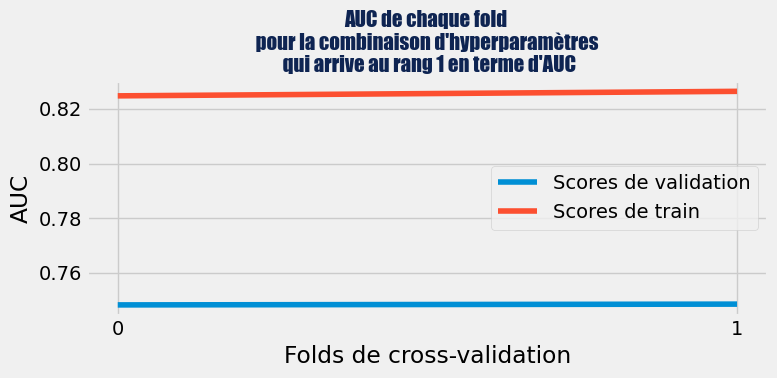

In [109]:
plot_auc_scores(best_auc_result_LGBM)

### 2.4.3 - Prédictions et métriques d'évaluation

In [110]:
result_lgbm=evaluate_model (X_train_sc, y_train, X_test_sc, y_test, best_model_lgbm)
result_lgbm

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 1.42,
 'auc_train': 0.79,
 'auc_test': 0.76,
 'optimal_threshold': 0.09,
 'f1_score_1_test': 0.27,
 'recall_1_test': 0.67,
 'accuracy_test': 0.7}

### 2.4.4 - Enregistrement dans ML Flow

In [111]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_lgbm)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_lgbm['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_lgbm['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_lgbm['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_lgbm['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_lgbm['auc_train'])
#     mlflow.log_metric("auc_test", result_lgbm['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_lgbm['predicting_execution_time'])

    
 
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "LGBM with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, best_model_lgbm.predict(X_train_sc)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_lgbm.named_steps['model'], # le modèle
#         artifact_path="lgbm_classifier_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


### 2.4.5 - Feature importance

In [112]:
importances = best_model_lgbm.named_steps['model'].feature_importances_
features= X_train_sc.columns

In [113]:
# show_feature_importances(importances, features)

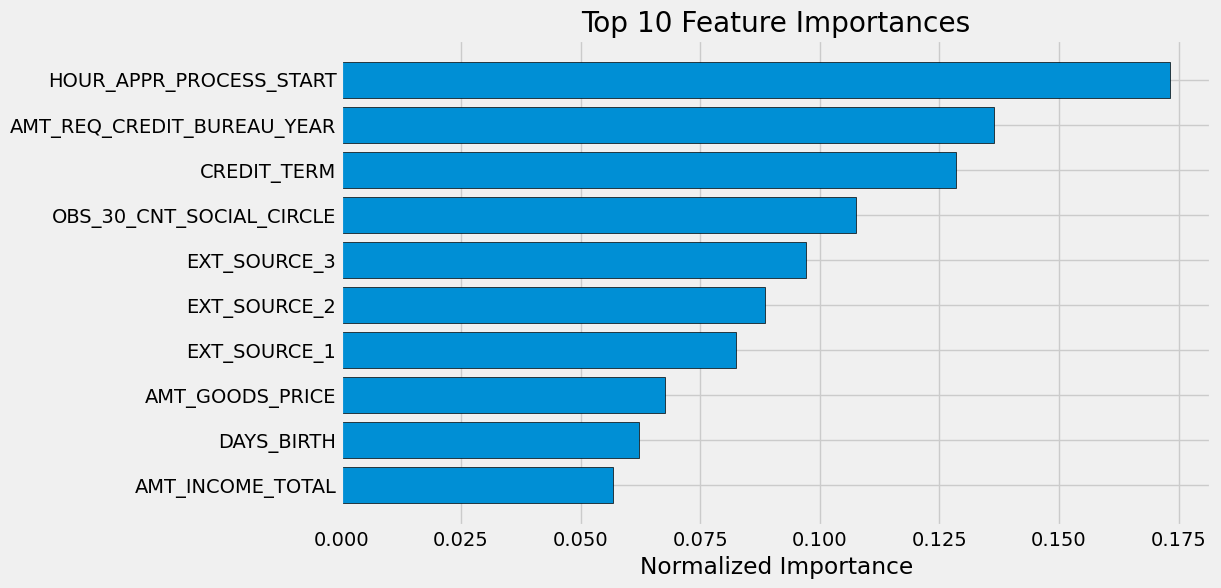

In [114]:
feature_importances_sorted=show_feature_importances(importances, features)

In [115]:
feature_importances_sorted

,feature,importance,importance_normalized
0,HOUR_APPR_PROCESS_START,348,0.173134
1,AMT_REQ_CREDIT_BUREAU_YEAR,274,0.136318
2,CREDIT_TERM,258,0.128358
3,OBS_30_CNT_SOCIAL_CIRCLE,216,0.107463
4,EXT_SOURCE_3,195,0.097015
5,EXT_SOURCE_2,178,0.088557
6,EXT_SOURCE_1,166,0.082587
7,AMT_GOODS_PRICE,136,0.067662
8,DAYS_BIRTH,125,0.062189
9,AMT_INCOME_TOTAL,114,0.056716


- 'HOUR_APPR_PROCESS_START' = À quelle heure environ le client a-t-il demandé le prêt ?
- 'AMT_REQ_CREDIT_BUREAU_YEAR' = Nombre de demandes de renseignements au bureau de crédit concernant le client par jour et par an (à l'exclusion des trois derniers mois précédant la demande)
- 'OBS_30_CNT_SOCIAL_CIRCLE' : nombre de fois où l' entourage  du client a eu des défauts de paiement > 30 jours après l'échéance prévue.
- 'CREDIT_TERM' : montant de la mensualité / montant du prêt

In [116]:
# feature_importances_sorted.to_csv('feature_importances_sorted_lgbm_1.csv', index=False)